In [ ]:
# Import necessary libraries
from google.colab import files
from google.colab import drive
import zipfile
import os
import torch
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define helper functions
def display_images(data, labels):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0][0]
        image = data[idx]
        axes[i].imshow(image.astype(np.uint8))
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

def load_pth(file_path):
    raw_data = torch.load(file_path)
    return raw_data['data'].numpy(), raw_data['labels'].numpy()

# **CNN Architectures:**

In [ ]:
def cnn_architecture_1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)  # Layer 1

    # First convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)  # Increased filters
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Reduced dropout rate

    # Second convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Increased filters
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Reduced dropout rate

    # Flatten and Dense layers
    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increased units
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model Total Parameters: {model.count_params()}")
    return model

def cnn_architecture_2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)  # Layer 1

    # First convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)  # Increased filters
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Reduced dropout rate

    # Second convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Increased filters
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Reduced dropout rate

    # Flatten and Dense layers
    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increased units
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model Total Parameters: {model.count_params()}")
    return model


def cnn_architecture_3(input_shape, num_classes):
    """CNN with smaller second Conv2D layer and early dropout for better generalization."""
    inputs = layers.Input(shape=input_shape)  # Layer 1
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)  # Layer 2
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Layer 4 (Early dropout)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Layer 5 (Reduced filters)
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Layer 7

    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(128, activation='relu')(x)  # Layer 9
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 3 Total Parameters: {model.count_params()}")
    return model


# **CNN Class:**

In [ ]:
# Define the CNNModel class
class CNNModel:
    def __init__(self, train_path, test_path, label_mapping, class_names, input_shape, architecture_fn, epochs=20):
        self.train_path = train_path
        self.test_path = test_path
        self.label_mapping = label_mapping
        self.class_names = class_names
        self.input_shape = input_shape
        self.epochs = epochs
        self.is_built = False
        self.model = None
        self.architecture_fn = architecture_fn

    def load_data(self):
      """Load and preprocess training and testing data."""
      train_data = torch.load(self.train_path, weights_only=True)  # Use weights_only=True for security
      test_data = torch.load(self.test_path, weights_only=True)  # Use weights_only=True for security

      # Convert data to numpy arrays
      X_train = train_data['data'].numpy()
      print(f"Shape of X_train: {X_train.shape}")  # Debugging
      y_train = np.array([self.label_mapping[int(label)] for label in train_data['labels']])

      X_test = test_data['data'].numpy()
      print(f"Shape of X_test: {X_test.shape}")  # Debugging
      y_test = np.array([self.label_mapping[int(label)] for label in test_data['labels']])

      return X_train, y_train, X_test, y_test

    def build_model(self):
        """Build and compile CNN model."""
        self.model = self.architecture_fn(self.input_shape, len(self.class_names))

        self.model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

        self.model.summary()
        self.is_built = True

    def train(self, X_train, y_train):
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")

        self.model.fit(X_train.astype(np.float32), y_train, epochs=self.epochs)

    def evaluate(self, X_test, y_test):
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")

        test_loss, test_accuracy = self.model.evaluate(X_test.astype(np.float32), y_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        return test_loss, test_accuracy

    def classification_report(self, X_test, y_test):
        """Generates a classification report."""
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")

        y_pred = np.argmax(self.model.predict(X_test.astype(np.float32)), axis=1)
        print(f"Classification Report:")
        print(classification_report(y_test, y_pred, target_names=self.class_names))

    def plot_confusion_matrix(self, X_test, y_test):
        """Plots the confusion matrix."""
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")

        y_pred = np.argmax(self.model.predict(X_test.astype(np.float32)), axis=1)
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def save(self, model_name):
        """Saves the trained model."""
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")

        self.model.save(model_name + ".h5")

    def get_model_weights(self):
        """Returns the model's weights."""
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")

        return self.model.get_weights()

### **Defining the input shape and epochs**

In [ ]:
# Define input shape and epochs
input_shape = (64, 64, 3)
epochs = 20


# **Model 1:**

In [ ]:
# Model 1
train_path_1 = "/content/drive/MyDrive/Task2_data/train_dataB_model_1.pth"
test_path_1 = "/content/drive/MyDrive/Task2_data/val_dataB_model_1.pth"
label_mapping_1 = {
    173: 0,   # Chihuahua -> 0
    137: 1,  # baboon -> 1
    34: 2,  #  hyena  -> 2
    159: 3,  # Arctic_fox -> 3
    201: 4   # lynx -> 4
}
Classes1 = ['Chihuahua', 'baboon', 'hyena', 'Arctic_fox', 'lynx']




<ipython-input-273-f100a69c6754>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_data = torch.load(file_path)


Displaying images for all classes:


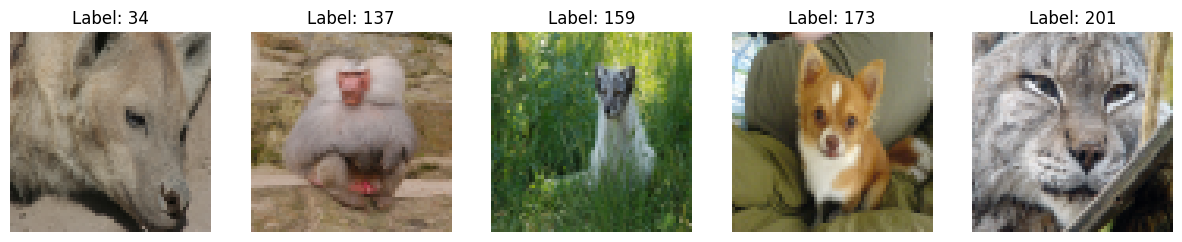

In [ ]:
if __name__ == '__main__':

    # Load and display images for each class in the dataset
    train_data, train_labels = load_pth('/content/drive/MyDrive/Task2_data/train_dataB_model_1.pth')
    print('Displaying images for all classes:')
    display_images(train_data, train_labels)

In [ ]:
# Train Model 1
model1 = CNNModel(train_path_1, test_path_1, label_mapping_1, Classes1, input_shape, cnn_architecture_1, epochs)

In [ ]:
X_train1, y_train1, X_test1, y_test1 = model1.load_data()
X_train1 = X_train1 / 255.0
X_test1 = X_test1 / 255.0

print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

Shape of X_train: (3197, 64, 64, 3)
Shape of X_test: (250, 64, 64, 3)
(3197, 64, 64, 3)
(3197,)
(250, 64, 64, 3)
(250,)


In [ ]:
model1.build_model()

Model Total Parameters: 3287685


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,287,685 (12.54 MB)

 Trainable params: 3,287,685 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


model1.train(X_train1, y_train1)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.2305 - loss: 2.6644
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4205 - loss: 1.4737
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4643 - loss: 1.3746
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4967 - loss: 1.3530
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4997 - loss: 1.3312
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5635 - loss: 1.2646
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5568 - loss: 1.2678
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5374 - loss: 1.2785
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5786 - loss: 1.2271
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5755 - loss: 1.2383
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6060 - loss: 1.1815
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms

In [ ]:
model1.evaluate(X_test1, y_test1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5481 - loss: 1.4202
Test Accuracy: 56.80%


(1.343708872795105, 0.5680000185966492)

In [ ]:
model1.classification_report(X_test1, y_test1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classification Report:
              precision    recall  f1-score   support

   Chihuahua       0.71      0.44      0.54        50
      baboon       0.42      0.52      0.46        50
       hyena       0.49      0.66      0.56        50
  Arctic_fox       0.78      0.62      0.69        50
        lynx       0.60      0.60      0.60        50

    accuracy                           0.57       250
   macro avg       0.60      0.57      0.57       250
weighted avg       0.60      0.57      0.57       250



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


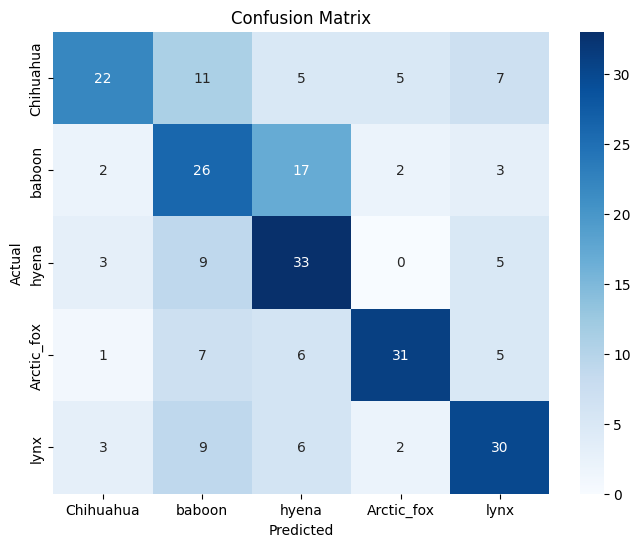

In [ ]:
model1.plot_confusion_matrix(X_test1, y_test1)

In [ ]:
model1.save("model1")

# **Model 2:**

In [ ]:
train_path_2 = "/content/drive/MyDrive/Task2_data/train_dataB_model_2.pth"
test_path_2 = "/content/drive/MyDrive/Task2_data/val_dataB_model_2.pth"

label_mapping_2 = {
    24: 0,   # African Elephant -> 0
    34: 1,   # Hyena -> 1
    80: 2,   # Zebra -> 2
    135: 3,  # Patas (a type of monkey) -> 3
    202: 4   # African Hunting Dog -> 4
}

Classes2 = ['African Elephant', 'Hyena', 'Zebra', 'Patas', 'African Hunting Dog']


<ipython-input-273-f100a69c6754>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_data = torch.load(file_path)


Displaying images for all classes:


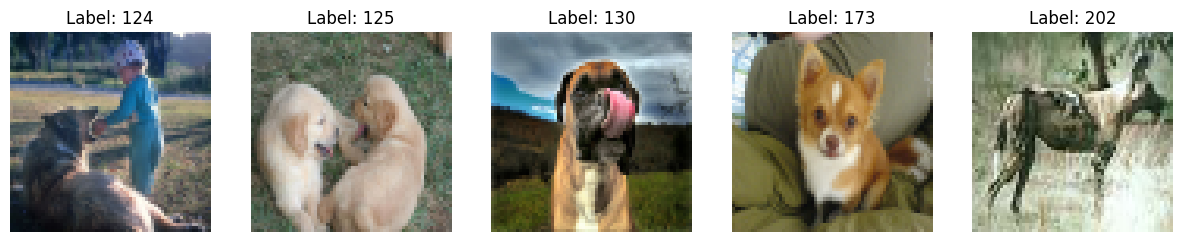

In [ ]:
if __name__ == '__main__':

    # Load and display images for each class in the dataset
    train_data, train_labels = load_pth('/content/drive/MyDrive/Task2_data/train_dataB_model_3.pth')
    print('Displaying images for all classes:')
    display_images(train_data, train_labels)

In [ ]:
# Train Model 2
model2 = CNNModel(train_path_2, test_path_2, label_mapping_2, Classes2, input_shape, cnn_architecture_2, epochs)

In [ ]:
X_train2, y_train2, X_test2, y_test2= model2.load_data()
X_train2 = X_train2 / 255.0
X_test2 = X_test2 / 255.0

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

Shape of X_train: (3222, 64, 64, 3)
Shape of X_test: (250, 64, 64, 3)
(3222, 64, 64, 3)
(3222,)
(250, 64, 64, 3)
(250,)


In [ ]:
model2.build_model()

Model Total Parameters: 3287685


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,287,685 (12.54 MB)

 Trainable params: 3,287,685 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.train(X_train2, y_train2)


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2115 - loss: 3.1181
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4287 - loss: 1.5157
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4760 - loss: 1.3486
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5075 - loss: 1.3053
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5083 - loss: 1.3054
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5525 - loss: 1.2474
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5709 - loss: 1.2206
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5521 - loss: 1.2205
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5948 - loss: 1.1556
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5971 - loss: 1.1405
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6106 - loss: 1.1380
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

In [ ]:
model2.evaluate(X_test2, y_test2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6303 - loss: 1.0580
Test Accuracy: 63.20%


(1.0391044616699219, 0.6320000290870667)

In [ ]:
model2.classification_report(X_test2, y_test2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classification Report:
                     precision    recall  f1-score   support

   African Elephant       0.67      0.66      0.67        50
              Hyena       0.48      0.60      0.54        50
              Zebra       0.93      0.74      0.82        50
              Patas       0.62      0.52      0.57        50
African Hunting Dog       0.56      0.64      0.60        50

           accuracy                           0.63       250
          macro avg       0.65      0.63      0.64       250
       weighted avg       0.65      0.63      0.64       250



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


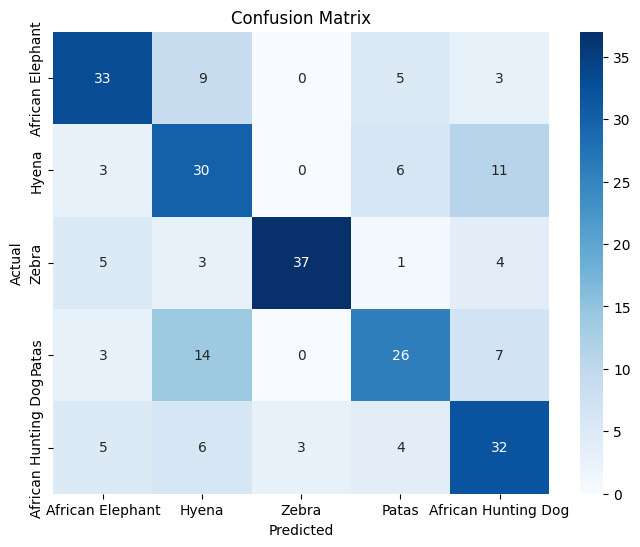

In [ ]:
model2.plot_confusion_matrix(X_test2, y_test2)

In [ ]:
model2.save("model2")

# **Model 3:**

In [ ]:
train_path_3 = "/content/drive/MyDrive/Task2_data/train_dataB_model_3.pth"
test_path_3 = "/content/drive/MyDrive/Task2_data/val_dataB_model_3.pth"

label_mapping_3 = {
    124: 0,  # Collie -> 0
    202: 1   # African Hunting Dog -> 1
}

Classes3 = ["Collie", "African Hunting Dog"]


In [ ]:
# Function to filter out unwanted classes
def filter_classes(X, y, label_mapping):
    """Filter out data and labels for classes not in the label mapping."""
    # Create a list of valid labels (keys in the label mapping)
    valid_labels = list(label_mapping.keys())

    # Filter data and labels
    mask = np.isin(y, valid_labels)
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Map the labels to the new label mapping
    y_filtered = np.array([label_mapping[int(label)] for label in y_filtered])

    return X_filtered, y_filtered

In [ ]:
# Load and preprocess data for Model 3
def load_data_model_3(train_path, test_path, label_mapping):
    """Load and preprocess data for Model 3, filtering out unwanted classes."""
    # Load raw data
    train_data = torch.load(train_path, weights_only=True)
    test_data = torch.load(test_path, weights_only=True)

    # Extract data and labels
    X_train = train_data['data'].numpy()
    y_train = train_data['labels'].numpy()
    X_test = test_data['data'].numpy()
    y_test = test_data['labels'].numpy()

    # Filter out unwanted classes
    X_train, y_train = filter_classes(X_train, y_train, label_mapping)
    X_test, y_test = filter_classes(X_test, y_test, label_mapping)

    # Normalize data
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_test, y_test

In [ ]:
# Load and preprocess data for Model 3
X_train3, y_train3, X_test3, y_test3 = load_data_model_3(train_path_3, test_path_3, label_mapping_3)

# Print shapes of the data
print(f"Shape of X_train3: {X_train3.shape}")
print(f"Shape of y_train3: {y_train3.shape}")
print(f"Shape of X_test3: {X_test3.shape}")
print(f"Shape of y_test3: {y_test3.shape}")


Shape of X_train3: (1273, 64, 64, 3)
Shape of y_train3: (1273,)
Shape of X_test3: (100, 64, 64, 3)
Shape of y_test3: (100,)


In [ ]:
# Train Model 3
model3 = CNNModel(train_path_3, test_path_3, label_mapping_3, Classes3, input_shape, cnn_architecture_3, epochs)


In [ ]:

# Build the model
model3.build_model()

Model 3 Total Parameters: 3287298


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,287,298 (12.54 MB)

 Trainable params: 3,287,298 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model3.train(X_train3, y_train3)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5090 - loss: 0.9374
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6157 - loss: 0.6689
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6609 - loss: 0.6316
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7082 - loss: 0.5820
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6620 - loss: 0.5910
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8032 - loss: 0.4399
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8001 - loss: 0.4155
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8608 - loss: 0.3497
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8750 - loss: 0.3089
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8772 - loss: 0.3133
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8658 - loss: 0.3244
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.

In [ ]:
# Evaluate the model
model3.evaluate(X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8798 - loss: 0.3173
Test Accuracy: 84.00%


(0.46771788597106934, 0.8399999737739563)

In [ ]:
# Generate classification report
model3.classification_report(X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Classification Report:
                     precision    recall  f1-score   support

             Collie       0.95      0.72      0.82        50
African Hunting Dog       0.77      0.96      0.86        50

           accuracy                           0.84       100
          macro avg       0.86      0.84      0.84       100
       weighted avg       0.86      0.84      0.84       100



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


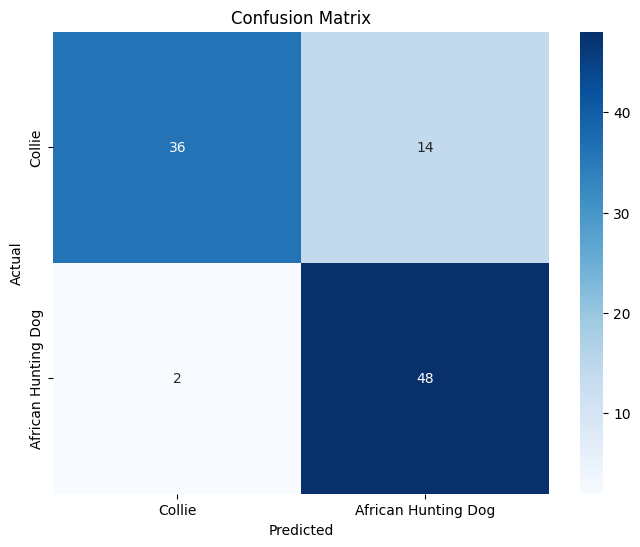

In [ ]:
# Plot confusion matrix
model3.plot_confusion_matrix(X_test3, y_test3)

In [ ]:
# Save the model
model3.save("model3")

# **Feature Level Fusion**

### **For Model 1, 2 and 3:**

In [ ]:
from keras import backend as K
import numpy as np

# Function to extract features from the penultimate layer
def extract_features(cnn_model, X):
    # Ensure the model is built by passing a dummy input through the call method

    feature_extractor = Model(inputs=cnn_model.model.input, outputs=cnn_model.model.layers[-3].output)
    return feature_extractor.predict(X.astype(np.float32))


# Extract features for training data
features_train1 = extract_features(model1, X_train1)
features_train2 = extract_features(model2, X_train2)
features_train3 = extract_features(model3, X_train3)

# Extract features for testing data
features_test1 = extract_features(model1, X_test1)
features_test2 = extract_features(model2, X_test2)
features_test3 = extract_features(model3, X_test3)


print(type(features_train1))
print(features_train1.shape)
print(features_train2.shape)
print(features_test1.shape)
print(features_test2.shape)
print(features_test3.shape)

# Feature-level fusion: Concatenation
fused_train_features = np.concatenate((features_train1, features_train2,features_train3), axis=0)
fused_test_features = np.concatenate((features_test1, features_test2,features_test3), axis=0)

print("fused_train_features",len(features_train1),len(features_train2),len(features_train3),"==",len(fused_train_features))
print("fused_test_features",len(features_test1),len(features_test2),len(features_test3),"==",len(fused_test_features))
# print("fuesed_test_feature")

# Define labels for fused model

y_train_fused = np.concatenate((y_train1, y_train2,y_train3), axis=0)
y_test_fused = np.concatenate((y_test1, y_test2,y_test3), axis=0)

# y_train_fused = y_train_fused[:2500]
# y_test_fused = y_test_fused[:500]

print("y_train_fused",len(y_train1),len(y_train2),len(y_train3),"==",len(y_train_fused))
print("y_test_fused",len(y_test1),len(y_test2),len(y_test3),"==",len(y_test_fused))

# Convert labels to categorical
num_classes = len(Classes1) + len(Classes2) + len(Classes3)

combined_classes_list = Classes1 + Classes2 + Classes3
print(combined_classes_list)
fused_train_features.shape

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
<class 'numpy.ndarray'>
(3197, 25088)
(3222, 25088)
(250, 25088)
(250, 25088)
(100, 25088)
fused_train_features 3197 3222 1273 == 7692
fused_test_features 250 250 100 == 600
y_train_fused 3197 3222 1273 == 7692
y_test_fused 250 250 100 == 600
['Chihuahua', 'baboon', 'hyena', 'Arctic_fox', 'lynx', 'African Elephant', 'Hyena', 'Zebra', 'Patas', 'African Hunting Dog', 'Collie', 'African Hunting Dog']


(7692, 25088)

In [ ]:
# Build classifier for fused features
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(fused_train_features.shape[1],))

dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(input_layer)  # Added L2 regularization
dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense1)        # Added L2 regularization
dense3 = layers.Dropout(0.3)(dense2)
dense4 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense3)        # Added L2 regularization
dense5 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense4)        # Added L2 regularization
dense6 = layers.Dropout(0.3)(dense5)
output_layer = Dense(num_classes, activation='softmax')(dense6)

fusion_model = Model(inputs=input_layer, outputs=output_layer)

# Compile fusion model
fusion_model.compile(optimizer=Adam(learning_rate=0.001),  # Adjusted learning rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
fusion_model.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)          │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,226,284 (12.31 MB)

 Trainable params: 3,226,284 (12.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train fusion model
fusion_model.fit(fused_train_features, y_train_fused, epochs=15, validation_data=(fused_test_features, y_test_fused))

Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3217 - loss: 3.4220 - val_accuracy: 0.5333 - val_loss: 1.7633
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5098 - loss: 1.7963 - val_accuracy: 0.6217 - val_loss: 1.4598
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5689 - loss: 1.5572 - val_accuracy: 0.6267 - val_loss: 1.3612
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5982 - loss: 1.4345 - val_accuracy: 0.6333 - val_loss: 1.3013
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6227 - loss: 1.3464 - val_accuracy: 0.6433 - val_loss: 1.2556
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6324 - loss: 1.3121 - val_accuracy: 0.6433 - val_loss: 1.2527
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6555 - loss: 1.2534 - val_accuracy: 0.6633 - val_loss: 1.2233
Epoch 8/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6560 - loss: 1.2455 - val_accuracy: 0

In [ ]:
# Evaluate fusion model
fusion_model.evaluate(fused_test_features, y_test_fused)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5818 - loss: 1.4018


[1.203273057937622, 0.6483333110809326]

In [ ]:
# Save the fused model
fusion_model.save("fusion_model.h5")